# datasets percents 

### Balanced

$>10\%  \rightarrow  U $

$10\%<x<36\% \rightarrow A $

$x>36\% \rightarrow D$ 

### Unbalanced 

$>30\% \rightarrow U$

$30\%<x<60\% \rightarrow A$

$x>60\% \rightarrow D$ 

# Imports 

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn.model_selection import LeaveOneOut
from sklearn.preprocessing import StandardScaler
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import label_binarize
from sklearn import metrics 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.linear_model import LogisticRegression

import imblearn
from imblearn.over_sampling import SMOTE

from itertools import cycle


import warnings
warnings.filterwarnings('ignore')


# Code

In [2]:
def plot_roc_curve(clf,Y_true,Y_pred):
    # using sklearn.metrics documation
    
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    classes = np.unique(Y_true)
    n_classes = len(classes)
    Y_true=label_binarize(Y_true,classes = classes)
    
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(Y_true[:, i], Y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(Y_true.ravel(), Y_pred.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # Plot ROC curves for the multiclass problem
    # Compute macro-average ROC curve and ROC area
    
    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    lw = 2
    
    # Plot all ROC curves
    plt.figure()
    plt.plot(
        fpr["micro"],
        tpr["micro"],
        label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
        color="deeppink",
        linestyle=":",
        linewidth=4,
    )

    plt.plot(
        fpr["macro"],
        tpr["macro"],
        label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
        color="navy",
        linestyle=":",
        linewidth=4,
    )

    colors = cycle(["aqua", "darkorange", "cornflowerblue"])
    for i, color in zip(range(n_classes), colors):
        plt.plot(
            fpr[i],
            tpr[i],
            color=color,
            lw=lw,
            label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc[i]),
        )

    plt.plot([0, 1], [0, 1], "k--", lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curves ({clf.__class__.__name__})")
    plt.legend(loc="lower right")
    plt.show()


def leave_one_out(X,Y,clf,normalize=True):
    # copying dataset not to change original
    X_cv = X.copy()
    Y_cv = Y.copy()

    np.random.seed(0)
    np.random.shuffle(X_cv)
    np.random.seed(0)
    np.random.shuffle(Y_cv)

    scaler = StandardScaler()
    Preds = []
    Y_true = []
    Y_score = []

    loo = LeaveOneOut()
    # for each iteration only one data point will be test set
    for train_index, test_index in loo.split(X_cv):
        X_train, X_test = X_cv[train_index], X_cv[test_index]
        Y_train, Y_test = Y_cv[train_index], Y_cv[test_index]

        if normalize:
            X_train = scaler.fit_transform(X_train)
            X_test = scaler.transform(X_test)

        # getting predictions
        clf.fit(X_train, Y_train)
        Preds.append(clf.predict(X_test))

        # adding true label associated to X_test
        Y_true.append(Y_test)

        # computation of Y_pred for the ROC Curve (probabilities)
        classifier = OneVsRestClassifier(clf)
        Y_train = label_binarize(Y_train, classes=np.unique(Y_train))
        Y_score.append((classifier.fit(X_train, Y_train).predict_proba(X_test))[0].tolist())

    classes = ['A', 'D', 'U']
    # confustion matrix 
    df_cm = pd.DataFrame(confusion_matrix(Y_true, Preds), index= classes, columns= classes)

    print("Confustion Matrix")
    plt.figure(figsize= (8,5))
    sns.heatmap(df_cm, annot= True)

    print(metrics.classification_report(Y_true,Preds))

    Y_true = np.array(Y_true)
    Y_score = np.array(Y_score)

    plot_roc_curve(clf,Y_true,Y_score)
    
    return clf, f1_score(Y_true, Preds, average="macro")


In [3]:
# add a random gaussian noise with very little standard deviation to simulate diversity in the data

np.random.seed(0)
df_balanced = pd.read_excel('Balanced.xlsx')

u = 0.1*np.random.random(size=len(df_balanced))
df_balanced['Duration (min)'] += u
u = 0.1*np.random.random(size=len(df_balanced))
df_balanced['Intensity(mW/cm^2)'] += u

np.random.seed(0)
df_unbalanced = pd.read_excel('Unbalanced.xlsx')

u = 0.1*np.random.random(size=len(df_unbalanced))
df_unbalanced['Duration (min)'] += u
u = 0.1*np.random.random(size=len(df_unbalanced))
df_unbalanced['Intensity(mW/cm^2)'] += u

In [4]:
# data bases
df_balanced_PDT = df_balanced[df_balanced[df_balanced.columns[0]]=='PDT']
df_unbalanced_PDT = df_unbalanced[df_unbalanced[df_unbalanced.columns[0]]=='PDT']

df_balanced_PTT = df_balanced[df_balanced[df_balanced.columns[0]]=='PTT']
df_unbalanced_PTT = df_unbalanced[df_unbalanced[df_unbalanced.columns[0]]=='PTT']

In [5]:
# finding how many results per cell state for every datasets
df_balanced_PDT[df_balanced_PDT.columns[-1]].value_counts()

Threshold Cell State (U,A,D)
D    21
U    14
A    13
Name: count, dtype: int64

In [6]:
df_balanced_PTT[df_balanced_PTT.columns[-1]].value_counts()

Threshold Cell State (U,A,D)
A    19
U    18
D    11
Name: count, dtype: int64

In [7]:
df_unbalanced_PDT[df_unbalanced_PDT.columns[-1]].value_counts()

Threshold Cell State (U,A,D)
U    26
D    14
A     8
Name: count, dtype: int64

In [8]:
df_unbalanced_PTT[df_unbalanced_PTT.columns[-1]].value_counts()

Threshold Cell State (U,A,D)
U    29
A    11
D     8
Name: count, dtype: int64

# I - PTT

### Visualization

In [9]:
# extracting x from database
X_balanced_PTT = df_balanced_PTT.iloc[:,1:3].values
Y_balanced_PTT = df_balanced_PTT.iloc[:,4].values

X_unbalanced_PTT = df_unbalanced_PTT.iloc[:,1:3].values
Y_unbalanced_PTT = df_unbalanced_PTT.iloc[:,4].values

oversample = SMOTE()
X_smote_PTT, Y_smote_PTT = oversample.fit_resample(X_unbalanced_PTT,Y_unbalanced_PTT)

In [10]:
np.unique(Y_balanced_PTT,return_counts=True)

(array(['A', 'D', 'U'], dtype=object), array([19, 11, 18], dtype=int64))

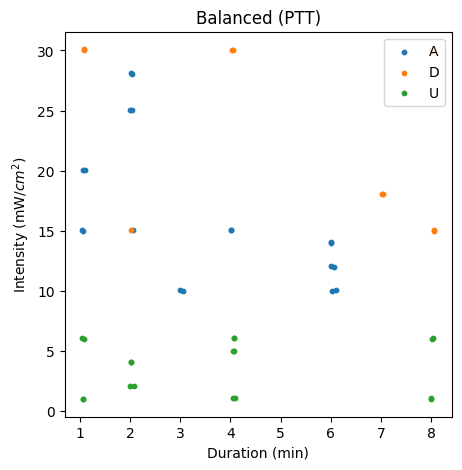

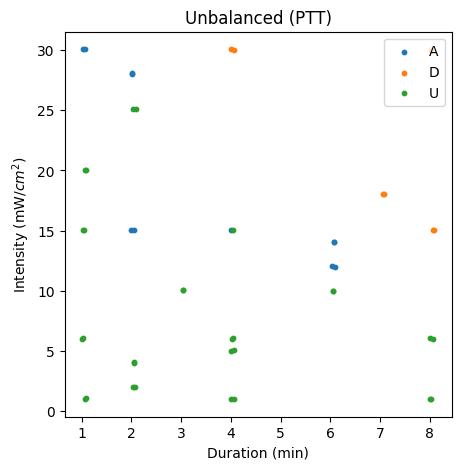

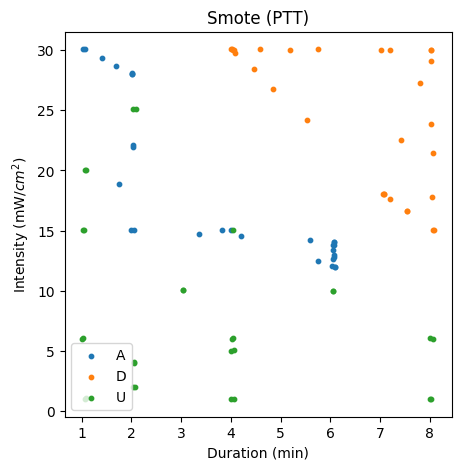

In [11]:
plt.figure(figsize=(5,5))

plt.scatter(X_balanced_PTT[Y_balanced_PTT=='A'][:,0],X_balanced_PTT[Y_balanced_PTT=='A'][:,1],label='A',s=10)
plt.scatter(X_balanced_PTT[Y_balanced_PTT=='D'][:,0],X_balanced_PTT[Y_balanced_PTT=='D'][:,1],label='D',s=10)
plt.scatter(X_balanced_PTT[Y_balanced_PTT=='U'][:,0],X_balanced_PTT[Y_balanced_PTT=='U'][:,1],label='U',s=10)

plt.legend()
plt.title('Balanced (PTT)')
plt.xlabel('Duration (min)')
plt.ylabel('Intensity (mW/$cm^2$)');

plt.figure(figsize=(5,5))

plt.scatter(X_unbalanced_PTT[Y_unbalanced_PTT=='A'][:,0],X_unbalanced_PTT[Y_unbalanced_PTT=='A'][:,1],label='A',s=10)
plt.scatter(X_unbalanced_PTT[Y_unbalanced_PTT=='D'][:,0],X_unbalanced_PTT[Y_unbalanced_PTT=='D'][:,1],label='D',s=10)
plt.scatter(X_unbalanced_PTT[Y_unbalanced_PTT=='U'][:,0],X_unbalanced_PTT[Y_unbalanced_PTT=='U'][:,1],label='U',s=10)

plt.legend()
plt.title('Unbalanced (PTT)')
plt.xlabel('Duration (min)')
plt.ylabel('Intensity (mW/$cm^2$)');

plt.figure(figsize=(5,5))

plt.scatter(X_smote_PTT[Y_smote_PTT=='A'][:,0],X_smote_PTT[Y_smote_PTT=='A'][:,1],label='A',s=10)
plt.scatter(X_smote_PTT[Y_smote_PTT=='D'][:,0],X_smote_PTT[Y_smote_PTT=='D'][:,1],label='D',s=10)
plt.scatter(X_smote_PTT[Y_smote_PTT=='U'][:,0],X_smote_PTT[Y_smote_PTT=='U'][:,1],label='U',s=10)

plt.legend()
plt.title('Smote (PTT)')
plt.xlabel('Duration (min)')
plt.ylabel('Intensity (mW/$cm^2$)');


We can see that the classes can be rather well separated using lines so it makes sense to use linear classifier for our problem.

### Linear SVM

Linear SVM
Balanced PTT
Confustion Matrix
              precision    recall  f1-score   support

           A       0.86      1.00      0.93        19
           D       1.00      0.73      0.84        11
           U       1.00      1.00      1.00        18

    accuracy                           0.94        48
   macro avg       0.95      0.91      0.92        48
weighted avg       0.95      0.94      0.93        48



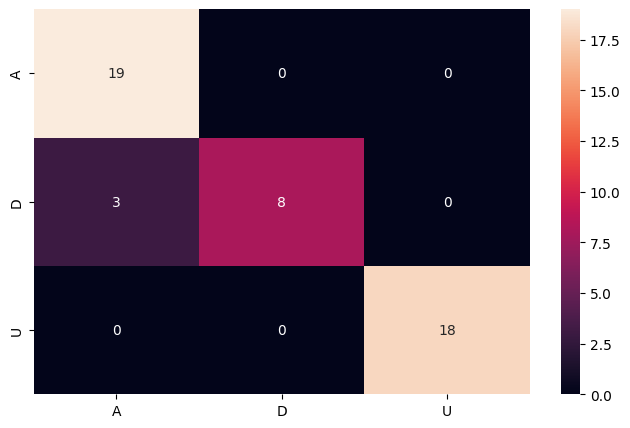

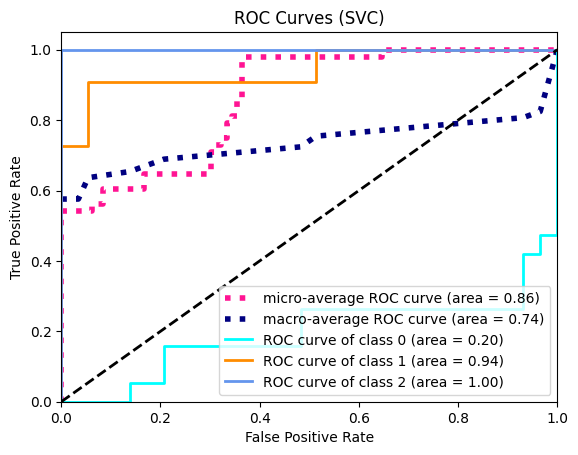

Unbalanced PTT
Confustion Matrix
              precision    recall  f1-score   support

           A       0.67      0.36      0.47        11
           D       1.00      1.00      1.00         8
           U       0.79      0.93      0.86        29

    accuracy                           0.81        48
   macro avg       0.82      0.76      0.78        48
weighted avg       0.80      0.81      0.79        48



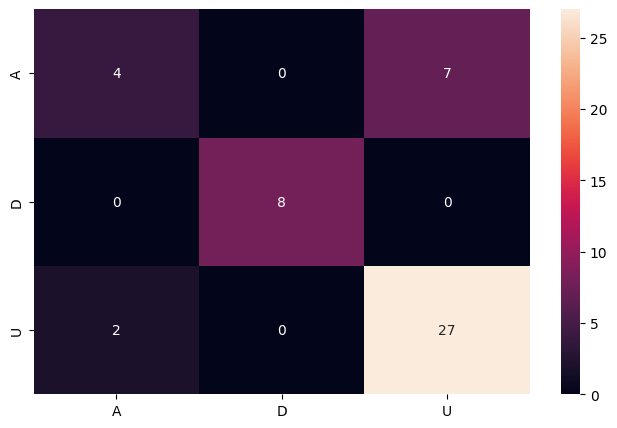

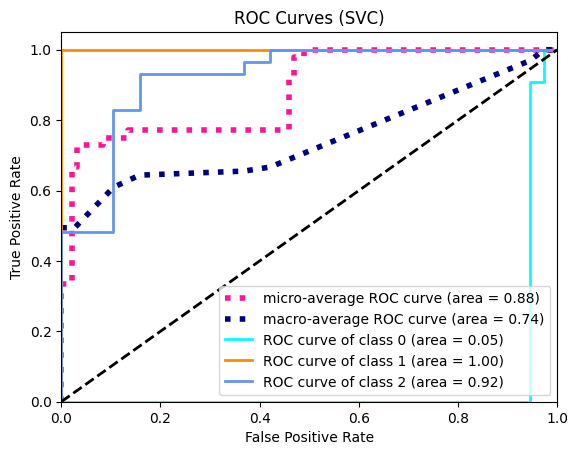

Smote PTT
Confustion Matrix
              precision    recall  f1-score   support

           A       0.75      0.93      0.83        29
           D       1.00      1.00      1.00        29
           U       0.91      0.69      0.78        29

    accuracy                           0.87        87
   macro avg       0.89      0.87      0.87        87
weighted avg       0.89      0.87      0.87        87



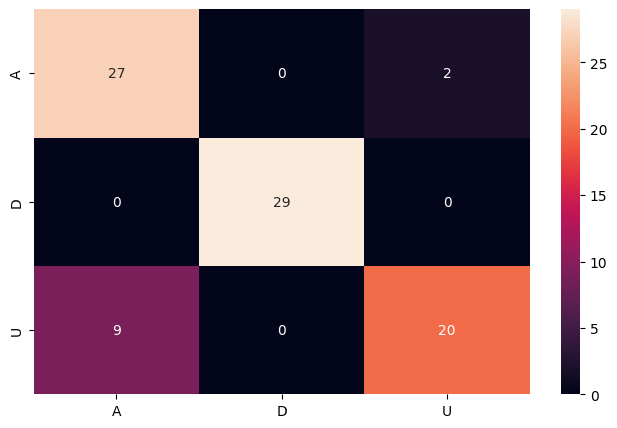

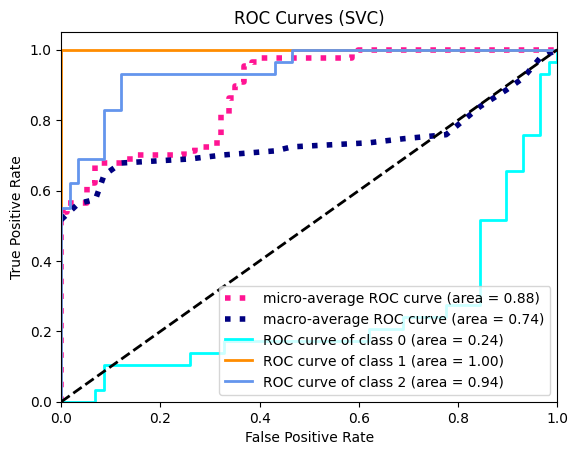

In [12]:
print('Linear SVM')
clfLinSVM = sklearn.svm.SVC(kernel='linear',probability=True,random_state=0)
print('Balanced PTT')
clf,linear_svm_f1_score_balanced_PTT = leave_one_out(X_balanced_PTT,Y_balanced_PTT,clfLinSVM,normalize=True)
print('Unbalanced PTT')
clf,linear_svm_f1_score_unbalanced_PTT = leave_one_out(X_unbalanced_PTT,Y_unbalanced_PTT,clfLinSVM,normalize=True)
print('Smote PTT')
clf,linear_svm_f1_score_smote_PTT = leave_one_out(X_smote_PTT,Y_smote_PTT,clfLinSVM,normalize=True)

### Gaussian SVM

Gaussian SVM
Balanced PTT
Confustion Matrix
              precision    recall  f1-score   support

           A       0.75      0.79      0.77        19
           D       0.75      0.55      0.63        11
           U       0.90      1.00      0.95        18

    accuracy                           0.81        48
   macro avg       0.80      0.78      0.78        48
weighted avg       0.81      0.81      0.80        48



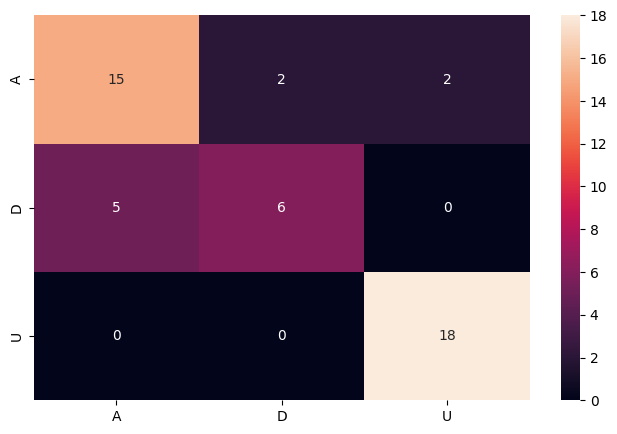

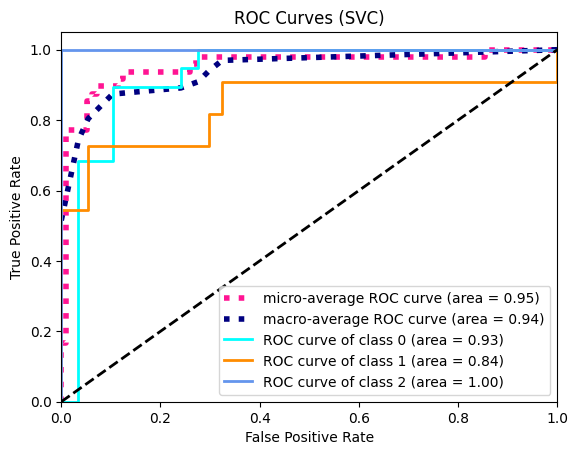

Unbalanced PTT
Confustion Matrix
              precision    recall  f1-score   support

           A       0.22      0.18      0.20        11
           D       1.00      0.75      0.86         8
           U       0.73      0.83      0.77        29

    accuracy                           0.67        48
   macro avg       0.65      0.59      0.61        48
weighted avg       0.66      0.67      0.66        48



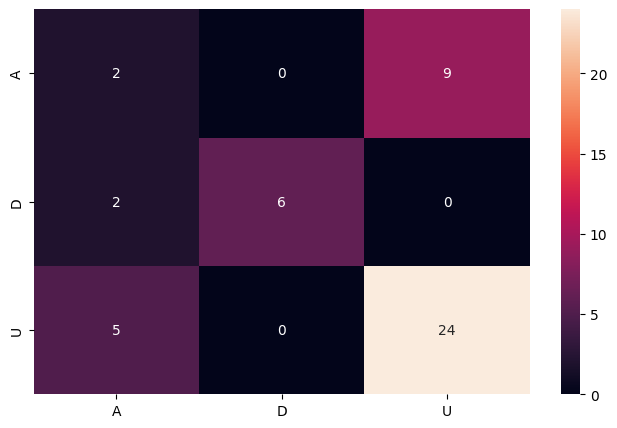

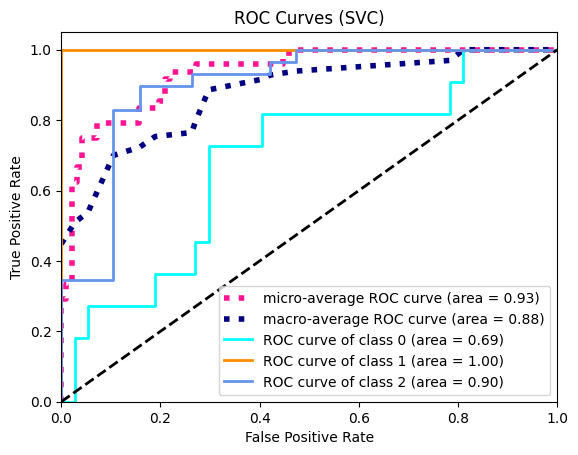

Smote PTT
Confustion Matrix
              precision    recall  f1-score   support

           A       0.79      0.90      0.84        29
           D       1.00      1.00      1.00        29
           U       0.88      0.76      0.81        29

    accuracy                           0.89        87
   macro avg       0.89      0.89      0.88        87
weighted avg       0.89      0.89      0.88        87



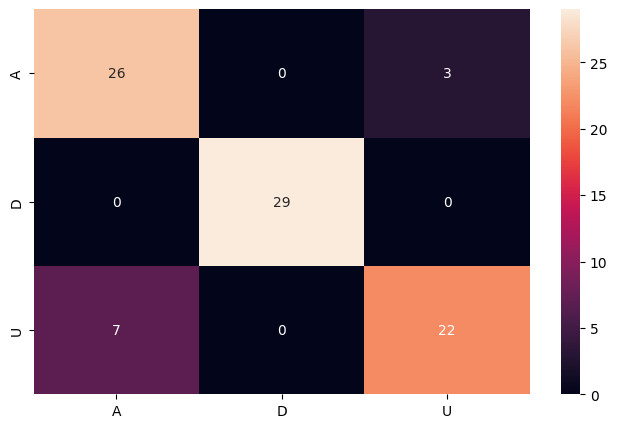

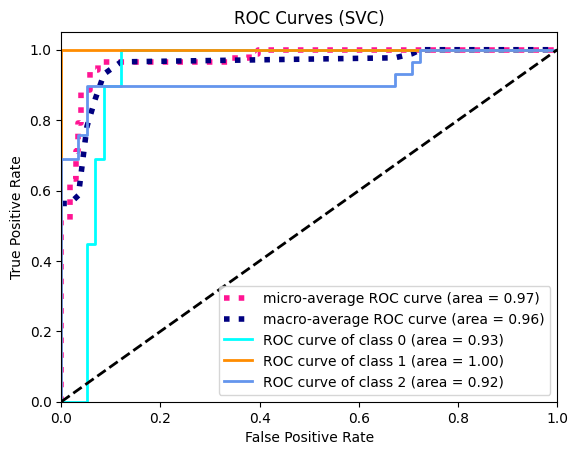

In [13]:
print('Gaussian SVM')
clfRbfSVM = sklearn.svm.SVC(kernel='rbf',probability=True,random_state=0)
print('Balanced PTT')
clf,rbf_svm_f1_score_balanced_PTT = leave_one_out(X_balanced_PTT,Y_balanced_PTT,clfRbfSVM,normalize=True)
print('Unbalanced PTT')
clf,rbf_svm_f1_score_unbalanced_PTT = leave_one_out(X_unbalanced_PTT,Y_unbalanced_PTT,clfRbfSVM,normalize=True)
print('Smote PTT')
clf,rbf_svm_f1_score_smote_PTT = leave_one_out(X_smote_PTT,Y_smote_PTT,clfRbfSVM,normalize=True)

### Polynomial SVM

Polynomial SVM
Balanced PTT
Confustion Matrix
              precision    recall  f1-score   support

           A       0.71      0.89      0.79        19
           D       0.80      0.73      0.76        11
           U       1.00      0.78      0.88        18

    accuracy                           0.81        48
   macro avg       0.84      0.80      0.81        48
weighted avg       0.84      0.81      0.82        48



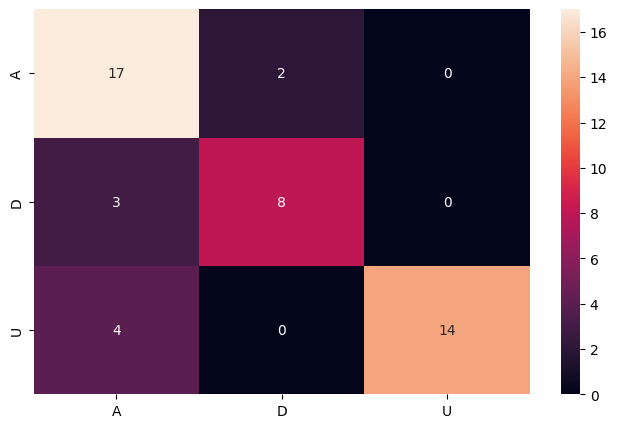

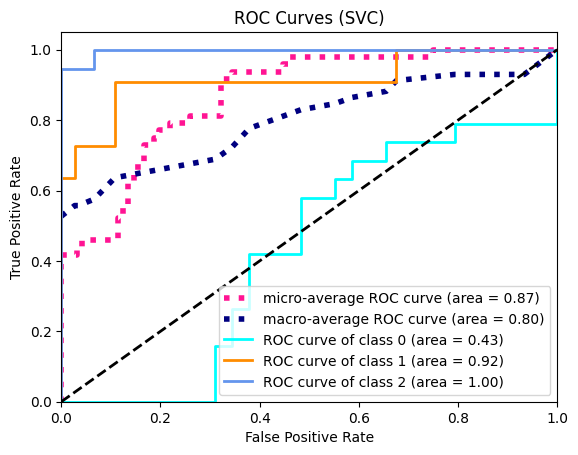

Unbalanced PTT
Confustion Matrix
              precision    recall  f1-score   support

           A       0.57      0.36      0.44        11
           D       1.00      0.88      0.93         8
           U       0.79      0.93      0.86        29

    accuracy                           0.79        48
   macro avg       0.79      0.72      0.74        48
weighted avg       0.78      0.79      0.78        48



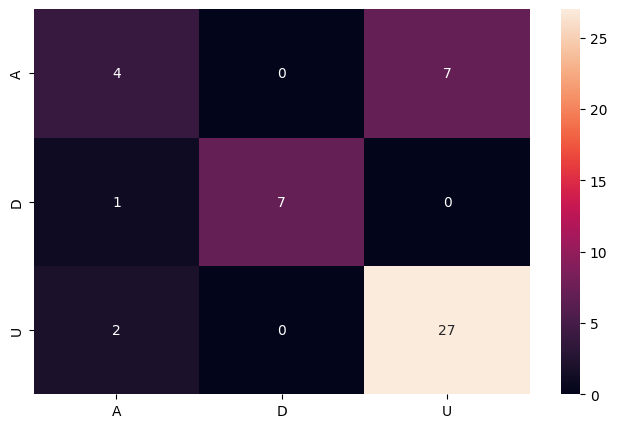

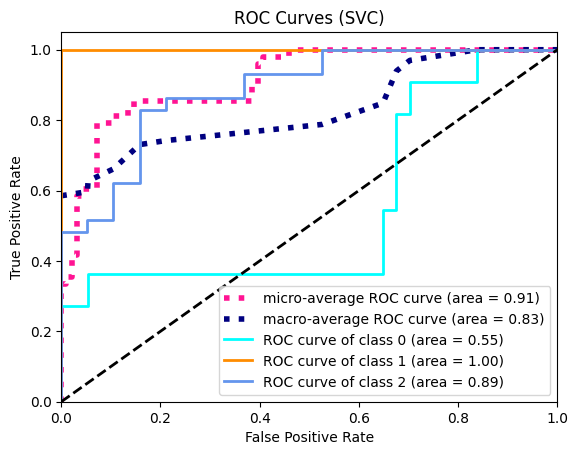

Smote PTT
Confustion Matrix
              precision    recall  f1-score   support

           A       0.67      1.00      0.81        29
           D       1.00      0.90      0.95        29
           U       1.00      0.62      0.77        29

    accuracy                           0.84        87
   macro avg       0.89      0.84      0.84        87
weighted avg       0.89      0.84      0.84        87



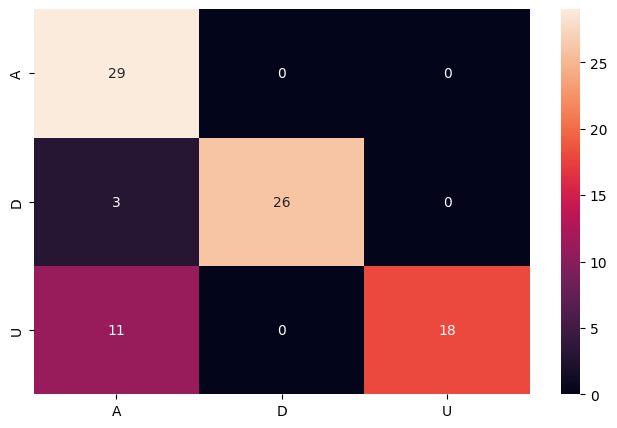

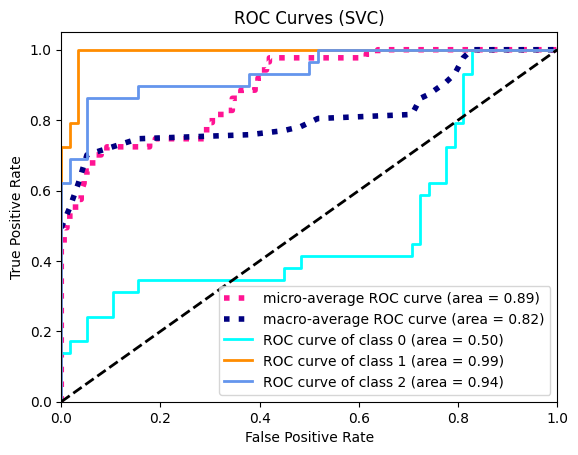

In [14]:
print('Polynomial SVM')
clfPolySVM = sklearn.svm.SVC(kernel='poly',probability=True,random_state=0)
print('Balanced PTT')
clf,poly_svm_f1_score_balanced_PTT = leave_one_out(X_balanced_PTT,Y_balanced_PTT,clfPolySVM,normalize=True)
print('Unbalanced PTT')
clf,poly_svm_f1_score_unbalanced_PTT = leave_one_out(X_unbalanced_PTT,Y_unbalanced_PTT,clfPolySVM,normalize=True)
print('Smote PTT')
clf,poly_svm_f1_score_smote_PTT = leave_one_out(X_smote_PTT,Y_smote_PTT,clfPolySVM,normalize=True)

### Decision Tree

Decision Tree Classifier
Balanced PTT
Confustion Matrix
              precision    recall  f1-score   support

           A       0.94      0.89      0.92        19
           D       0.83      0.91      0.87        11
           U       1.00      1.00      1.00        18

    accuracy                           0.94        48
   macro avg       0.93      0.93      0.93        48
weighted avg       0.94      0.94      0.94        48



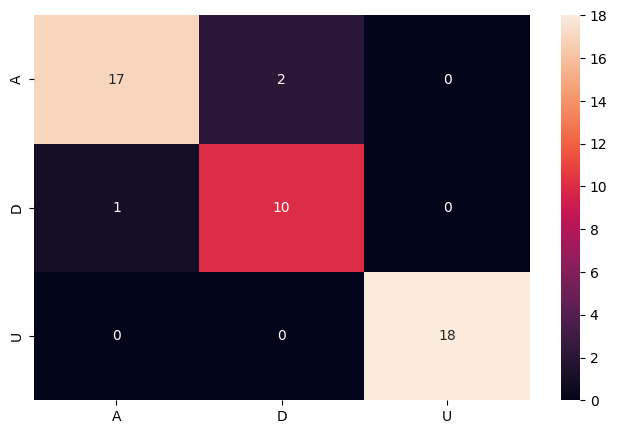

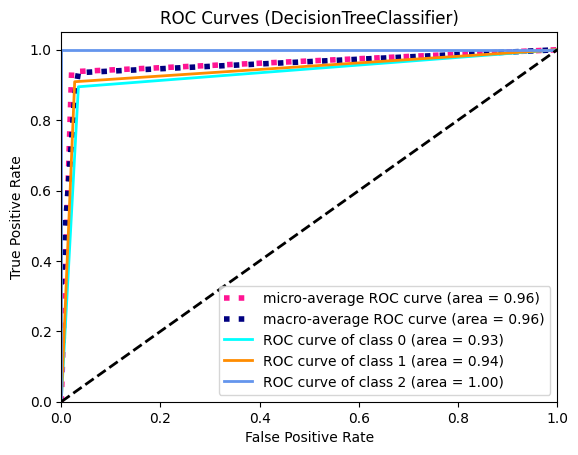

Unbalanced PTT
Confustion Matrix
              precision    recall  f1-score   support

           A       0.69      0.82      0.75        11
           D       1.00      1.00      1.00         8
           U       0.93      0.86      0.89        29

    accuracy                           0.88        48
   macro avg       0.87      0.89      0.88        48
weighted avg       0.88      0.88      0.88        48



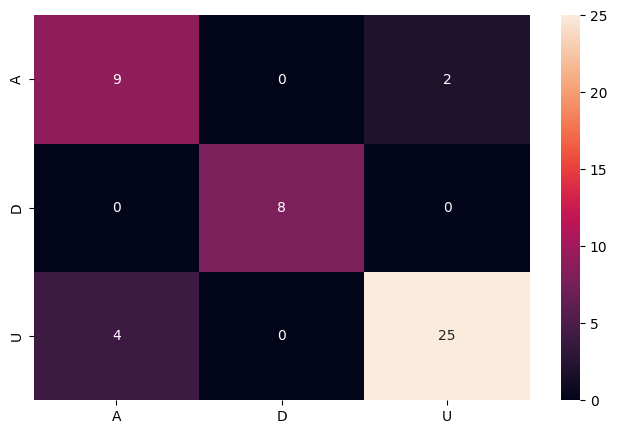

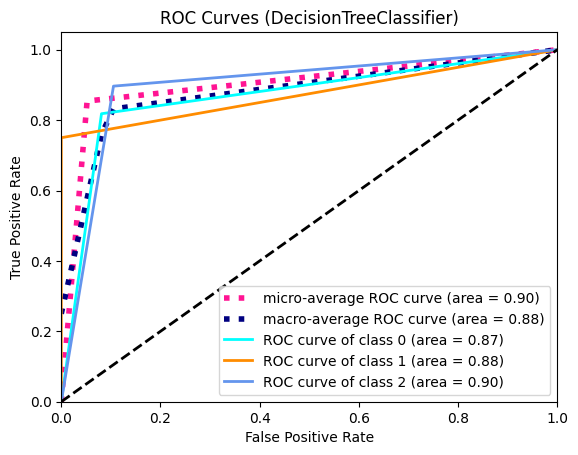

Smote PTT
Confustion Matrix
              precision    recall  f1-score   support

           A       0.94      1.00      0.97        29
           D       1.00      0.97      0.98        29
           U       0.96      0.93      0.95        29

    accuracy                           0.97        87
   macro avg       0.97      0.97      0.97        87
weighted avg       0.97      0.97      0.97        87



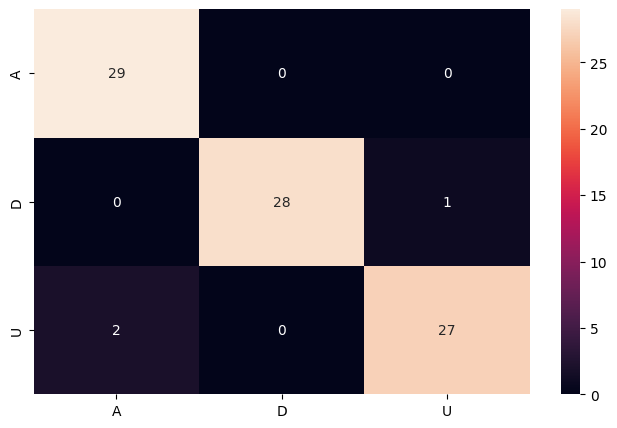

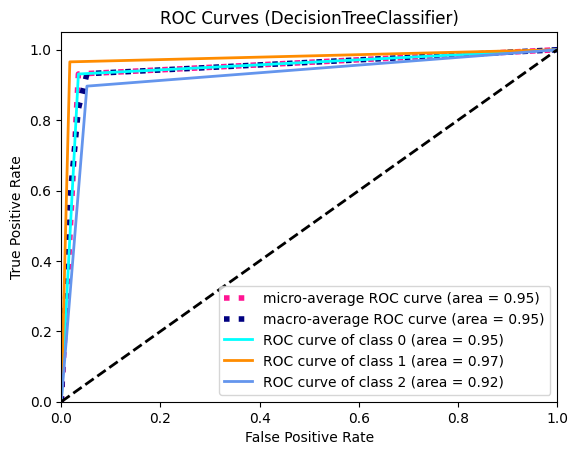

In [15]:
print('Decision Tree Classifier')
clfTree = DecisionTreeClassifier(random_state=0)
print('Balanced PTT')
clf,tree_f1_score_balanced_PTT = leave_one_out(X_balanced_PTT,Y_balanced_PTT,clfTree,normalize=True)
print('Unbalanced PTT')
clf,tree_f1_score_unbalanced_PTT = leave_one_out(X_unbalanced_PTT,Y_unbalanced_PTT,clfTree,normalize=True)
print('Smote PTT')
clf,tree_f1_score_smote_PTT = leave_one_out(X_smote_PTT,Y_smote_PTT,clfTree,normalize=True)

Balanced PTT
Confustion Matrix
              precision    recall  f1-score   support

           A       0.94      0.89      0.92        19
           D       0.83      0.91      0.87        11
           U       1.00      1.00      1.00        18

    accuracy                           0.94        48
   macro avg       0.93      0.93      0.93        48
weighted avg       0.94      0.94      0.94        48



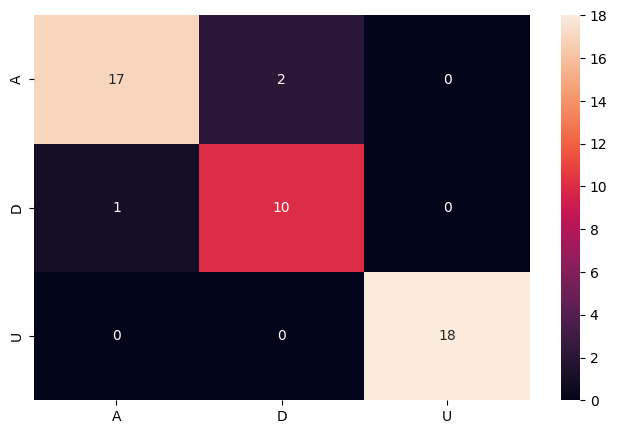

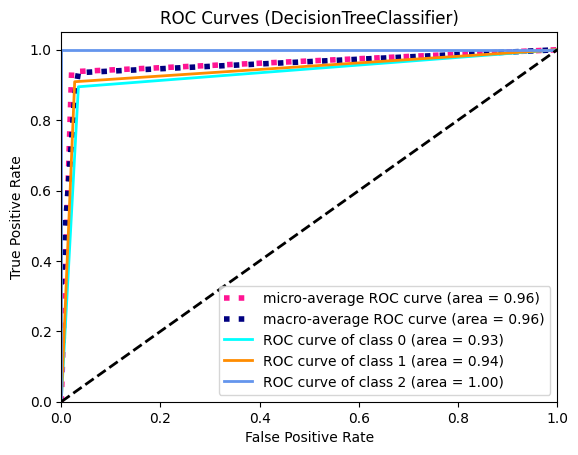

In [16]:
clfTree = DecisionTreeClassifier(random_state=0)
print('Balanced PTT')
clf,tree_f1_score_balanced_PTT = leave_one_out(X_balanced_PTT,Y_balanced_PTT,clfTree,normalize=False)

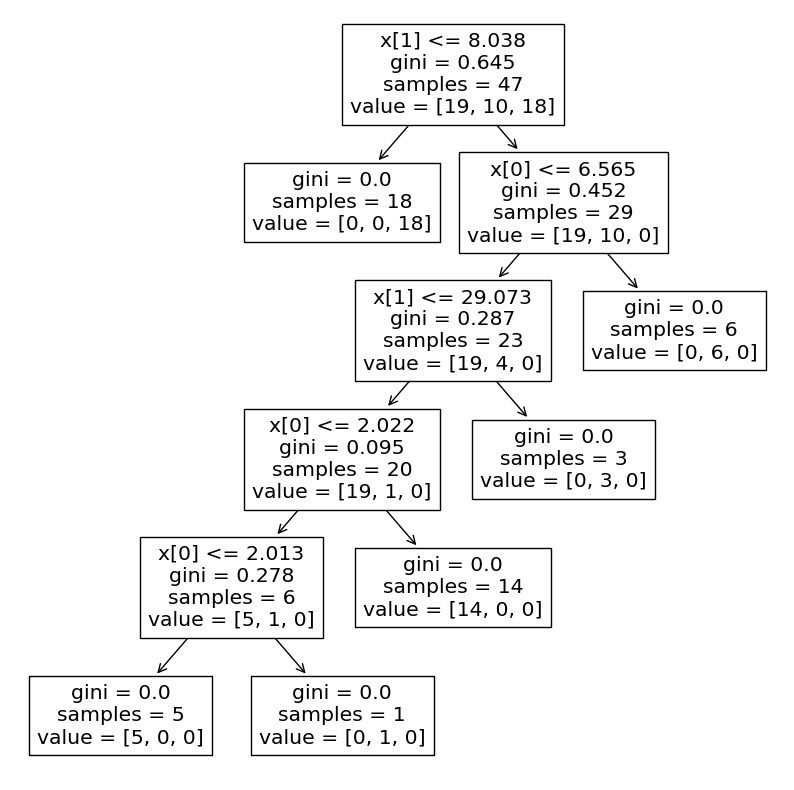

In [17]:
plt.figure(figsize=(10,10))
tree.plot_tree(clf);

### Logistic Regression

Logistic Regression
Balanced PTT
Confustion Matrix
              precision    recall  f1-score   support

           A       0.86      1.00      0.93        19
           D       1.00      0.73      0.84        11
           U       1.00      1.00      1.00        18

    accuracy                           0.94        48
   macro avg       0.95      0.91      0.92        48
weighted avg       0.95      0.94      0.93        48



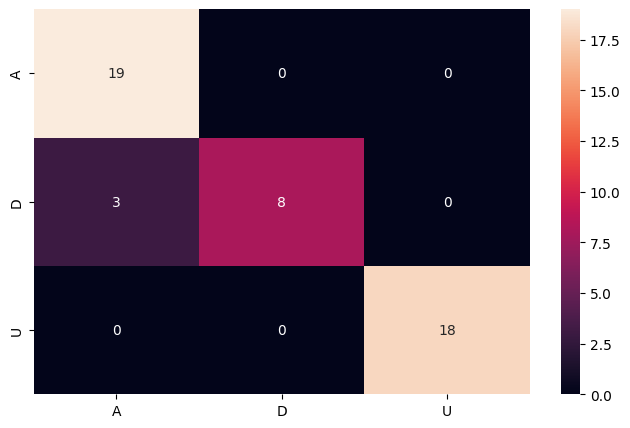

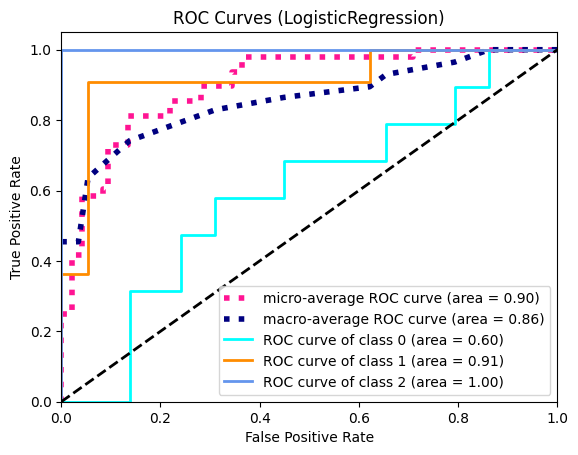

Unbalanced PTT
Confustion Matrix
              precision    recall  f1-score   support

           A       0.57      0.36      0.44        11
           D       1.00      0.88      0.93         8
           U       0.79      0.93      0.86        29

    accuracy                           0.79        48
   macro avg       0.79      0.72      0.74        48
weighted avg       0.78      0.79      0.78        48



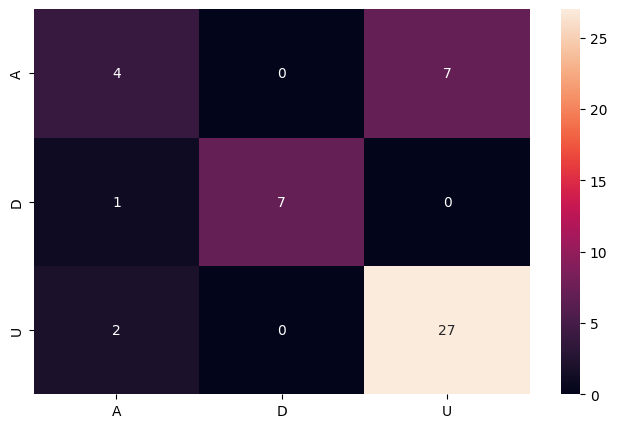

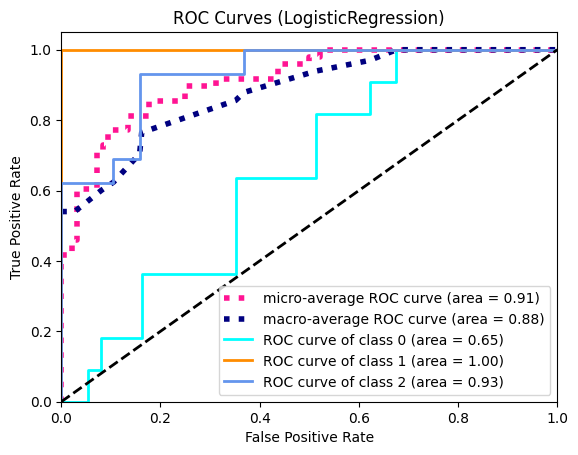

Smote PTT
Confustion Matrix
              precision    recall  f1-score   support

           A       0.74      0.90      0.81        29
           D       1.00      1.00      1.00        29
           U       0.87      0.69      0.77        29

    accuracy                           0.86        87
   macro avg       0.87      0.86      0.86        87
weighted avg       0.87      0.86      0.86        87



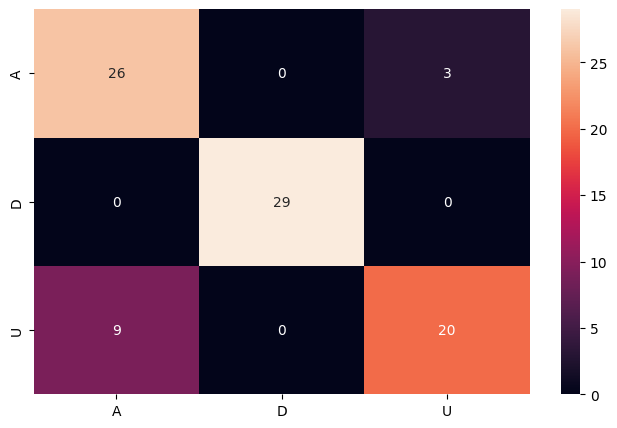

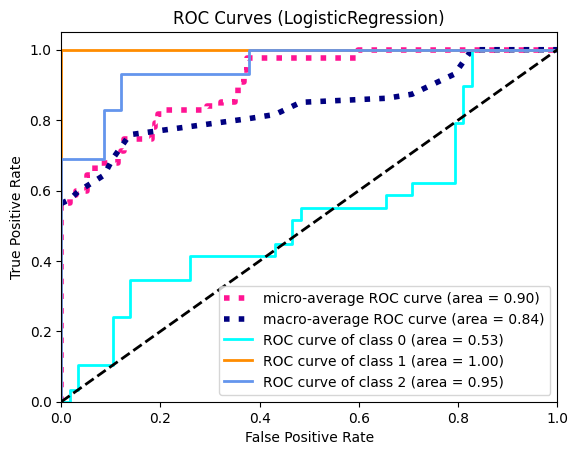

In [18]:
print('Logistic Regression')
clfLogreg = LogisticRegression(random_state=0)
print('Balanced PTT')
clf,Logreg_f1_score_balanced_PTT = leave_one_out(X_balanced_PTT,Y_balanced_PTT,clfLogreg,normalize=True)
print('Unbalanced PTT')
clf,Logreg_f1_score_unbalanced_PTT = leave_one_out(X_unbalanced_PTT,Y_unbalanced_PTT,clfLogreg,normalize=True)
print('Smote PTT')
clf,Logreg_f1_score_smote_PTT = leave_one_out(X_smote_PTT,Y_smote_PTT,clfLogreg,normalize=True)

### Comparison Balanced / Unbalanced

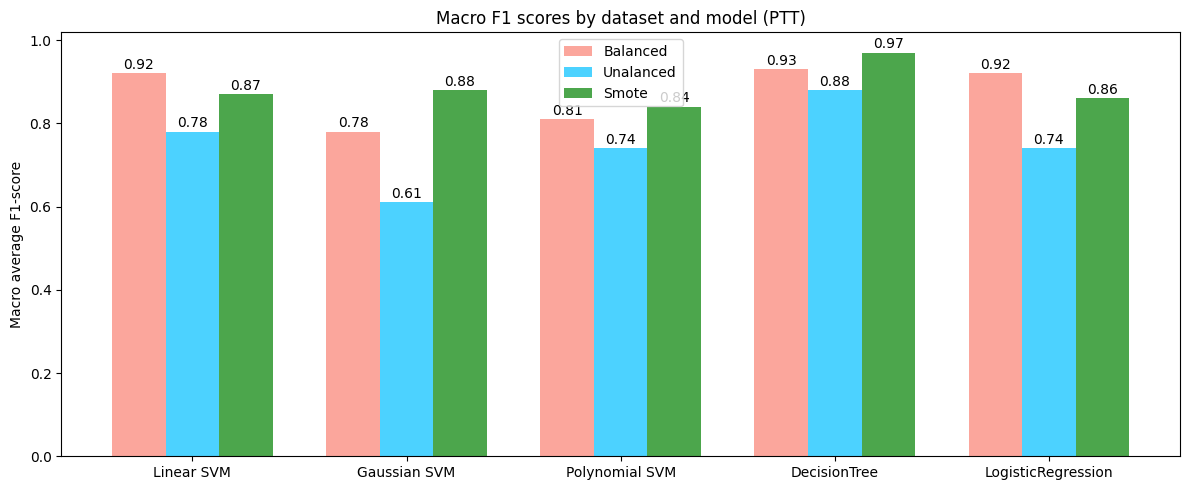

In [19]:
labels = ['Linear SVM', 'Gaussian SVM', 'Polynomial SVM', 'DecisionTree', 'LogisticRegression']
b_means = np.round([linear_svm_f1_score_balanced_PTT,rbf_svm_f1_score_balanced_PTT,poly_svm_f1_score_balanced_PTT,tree_f1_score_balanced_PTT,Logreg_f1_score_balanced_PTT],2)
ub_means = np.round([linear_svm_f1_score_unbalanced_PTT,rbf_svm_f1_score_unbalanced_PTT,poly_svm_f1_score_unbalanced_PTT,tree_f1_score_unbalanced_PTT,Logreg_f1_score_unbalanced_PTT],2)
smote_means = np.round([linear_svm_f1_score_smote_PTT,rbf_svm_f1_score_smote_PTT,poly_svm_f1_score_smote_PTT,tree_f1_score_smote_PTT,Logreg_f1_score_smote_PTT],2)

x = np.arange(len(labels)) # lables locations
width = 0.25 # width of the bars

fig, ax = plt.subplots(figsize=(12,5))
bar1 = ax.bar(x - width, b_means, width, label='Balanced', color='salmon',alpha=0.7)
bar2 = ax.bar(x, ub_means, width, label='Unalanced', color='deepskyblue',alpha=0.7)
bar3 = ax.bar(x + width, smote_means, width, label='Smote', color='green',alpha=0.7)

ax.set_ylabel('Macro average F1-score')
ax.set_title('Macro F1 scores by dataset and model (PTT)')
ax.set_xticks(x,labels)
ax.legend()

ax.bar_label(bar1,padding=1)
ax.bar_label(bar2,padding=1)
ax.bar_label(bar3,padding=1)

fig.tight_layout()

plt.show()

# II - PDT

### Visualization

In [20]:
# extracting x from database
X_balanced_PDT = df_balanced_PDT.iloc[:,1:3].values
Y_balanced_PDT = df_balanced_PDT.iloc[:,4].values

X_unbalanced_PDT = df_unbalanced_PDT.iloc[:,1:3].values
Y_unbalanced_PDT = df_unbalanced_PDT.iloc[:,4].values

oversample = SMOTE()
X_smote_PDT, Y_smote_PDT = oversample.fit_resample(X_unbalanced_PDT,Y_unbalanced_PDT)

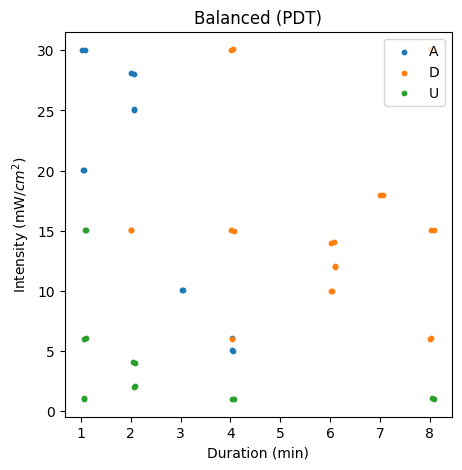

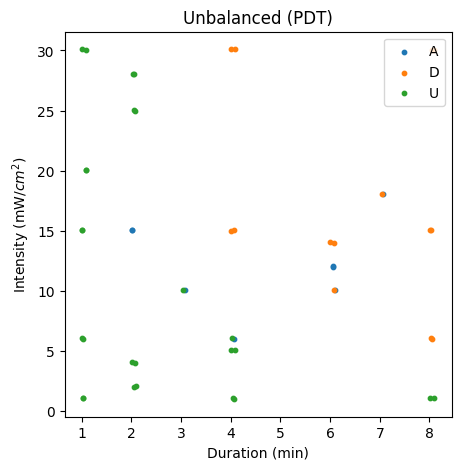

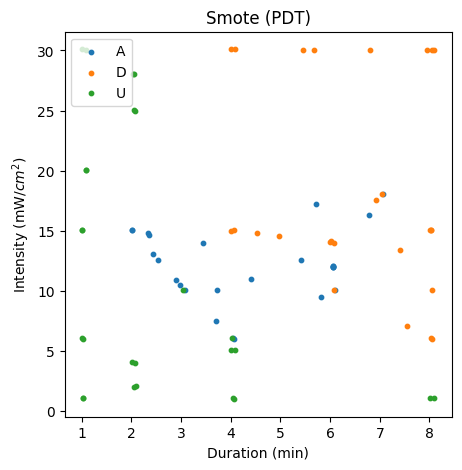

In [21]:
plt.figure(figsize=(5,5))

plt.scatter(X_balanced_PDT[Y_balanced_PDT=='A'][:,0],X_balanced_PDT[Y_balanced_PDT=='A'][:,1],label='A',s=10)
plt.scatter(X_balanced_PDT[Y_balanced_PDT=='D'][:,0],X_balanced_PDT[Y_balanced_PDT=='D'][:,1],label='D',s=10)
plt.scatter(X_balanced_PDT[Y_balanced_PDT=='U'][:,0],X_balanced_PDT[Y_balanced_PDT=='U'][:,1],label='U',s=10)

plt.legend()
plt.title('Balanced (PDT)')
plt.xlabel('Duration (min)')
plt.ylabel('Intensity (mW/$cm^2$)');

plt.figure(figsize=(5,5))

plt.scatter(X_unbalanced_PDT[Y_unbalanced_PDT=='A'][:,0],X_unbalanced_PDT[Y_unbalanced_PDT=='A'][:,1],label='A',s=10)
plt.scatter(X_unbalanced_PDT[Y_unbalanced_PDT=='D'][:,0],X_unbalanced_PDT[Y_unbalanced_PDT=='D'][:,1],label='D',s=10)
plt.scatter(X_unbalanced_PDT[Y_unbalanced_PDT=='U'][:,0],X_unbalanced_PDT[Y_unbalanced_PDT=='U'][:,1],label='U',s=10)

plt.legend()
plt.title('Unbalanced (PDT)')
plt.xlabel('Duration (min)')
plt.ylabel('Intensity (mW/$cm^2$)');

plt.figure(figsize=(5,5))

plt.scatter(X_smote_PDT[Y_smote_PDT=='A'][:,0],X_smote_PDT[Y_smote_PDT=='A'][:,1],label='A',s=10)
plt.scatter(X_smote_PDT[Y_smote_PDT=='D'][:,0],X_smote_PDT[Y_smote_PDT=='D'][:,1],label='D',s=10)
plt.scatter(X_smote_PDT[Y_smote_PDT=='U'][:,0],X_smote_PDT[Y_smote_PDT=='U'][:,1],label='U',s=10)

plt.legend()
plt.title('Smote (PDT)')
plt.xlabel('Duration (min)')
plt.ylabel('Intensity (mW/$cm^2$)');


### Linear SVM

Linear SVM
Balanced PDT
Confustion Matrix
              precision    recall  f1-score   support

           A       0.62      0.77      0.69        13
           D       0.89      0.76      0.82        21
           U       0.71      0.71      0.71        14

    accuracy                           0.75        48
   macro avg       0.74      0.75      0.74        48
weighted avg       0.77      0.75      0.75        48



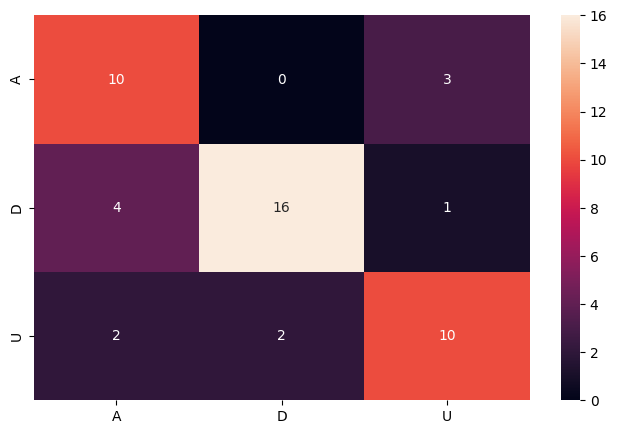

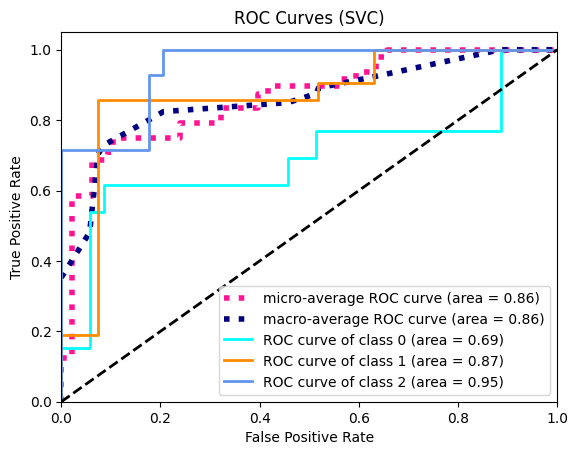

Unbalanced PDT
Confustion Matrix
              precision    recall  f1-score   support

           A       0.00      0.00      0.00         8
           D       0.67      0.86      0.75        14
           U       0.80      0.92      0.86        26

    accuracy                           0.75        48
   macro avg       0.49      0.59      0.54        48
weighted avg       0.63      0.75      0.68        48



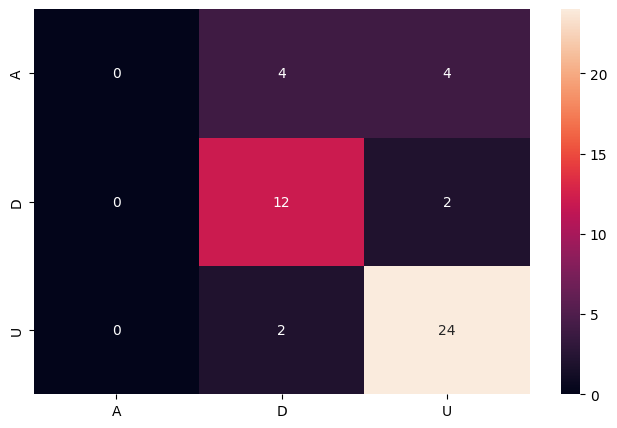

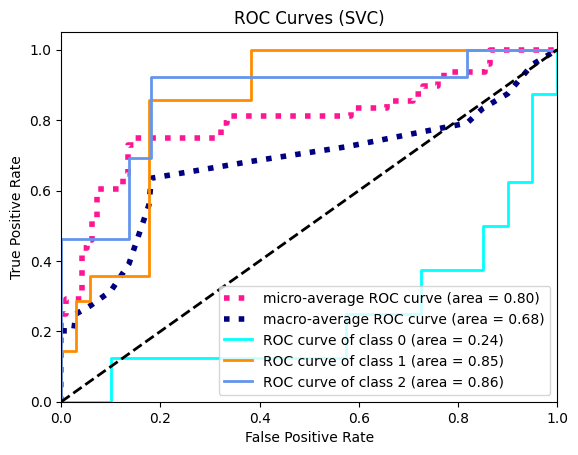

Smote PDT
Confustion Matrix
              precision    recall  f1-score   support

           A       0.29      0.15      0.20        26
           D       0.64      0.81      0.71        26
           U       0.61      0.73      0.67        26

    accuracy                           0.56        78
   macro avg       0.51      0.56      0.53        78
weighted avg       0.51      0.56      0.53        78



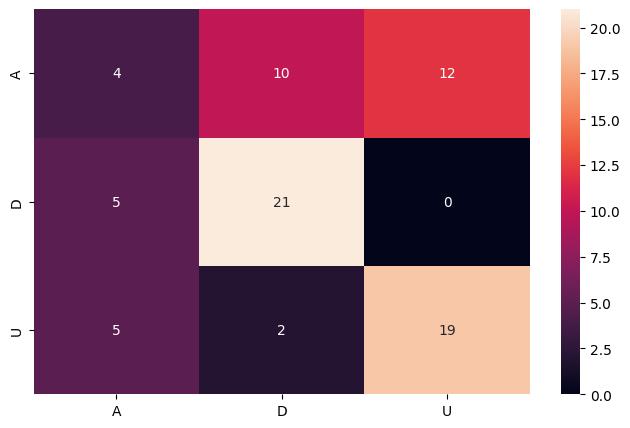

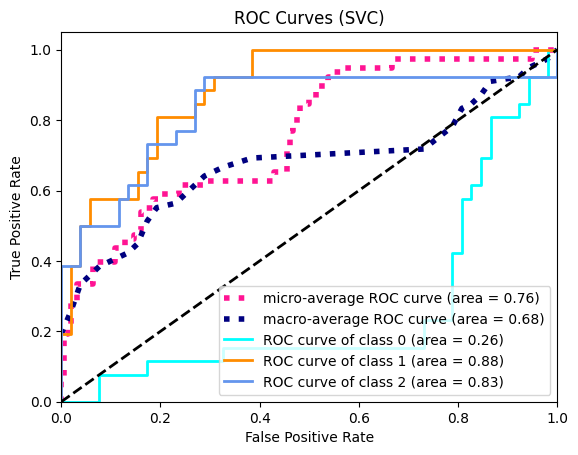

In [22]:
print('Linear SVM')
clfLinSVM = sklearn.svm.SVC(kernel='linear',probability=True,random_state=0)
print('Balanced PDT')
clf,linear_svm_f1_score_balanced_PDT = leave_one_out(X_balanced_PDT,Y_balanced_PDT,clfLinSVM,normalize=True)
print('Unbalanced PDT')
clf,linear_svm_f1_score_unbalanced_PDT = leave_one_out(X_unbalanced_PDT,Y_unbalanced_PDT,clfLinSVM,normalize=True)
print('Smote PDT')
clf,linear_svm_f1_score_smote_PDT = leave_one_out(X_smote_PDT,Y_smote_PDT,clfLinSVM,normalize=True)

### Gaussian SVM

Gaussian SVM
Balanced PDT
Confustion Matrix
              precision    recall  f1-score   support

           A       0.64      0.69      0.67        13
           D       0.84      0.76      0.80        21
           U       0.67      0.71      0.69        14

    accuracy                           0.73        48
   macro avg       0.72      0.72      0.72        48
weighted avg       0.74      0.73      0.73        48



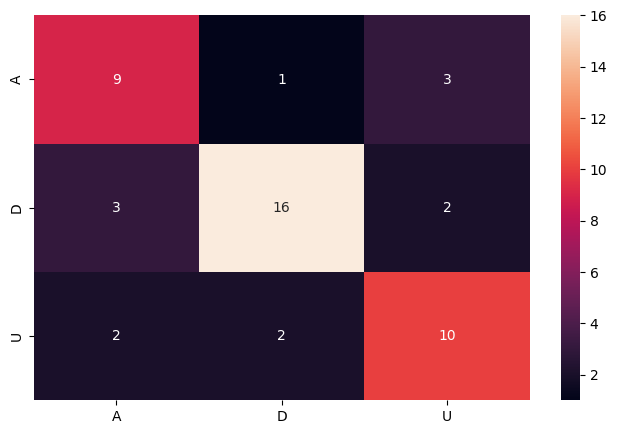

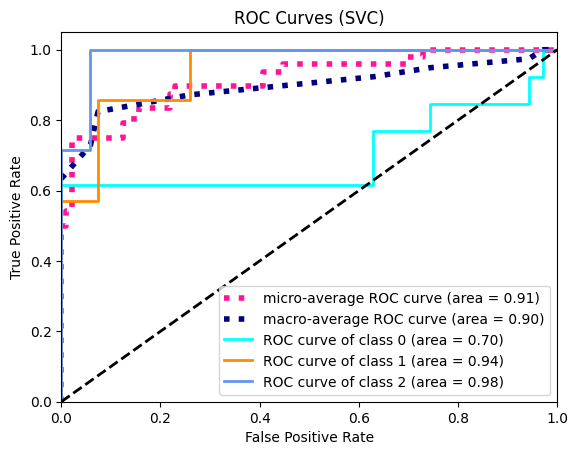

Unbalanced PDT
Confustion Matrix
              precision    recall  f1-score   support

           A       0.00      0.00      0.00         8
           D       0.62      0.71      0.67        14
           U       0.80      0.92      0.86        26

    accuracy                           0.71        48
   macro avg       0.48      0.55      0.51        48
weighted avg       0.62      0.71      0.66        48



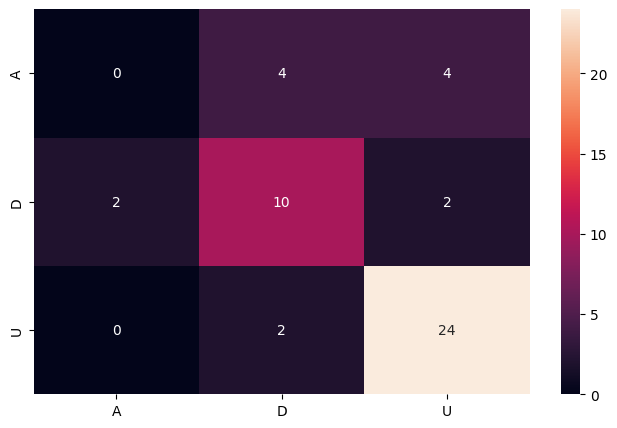

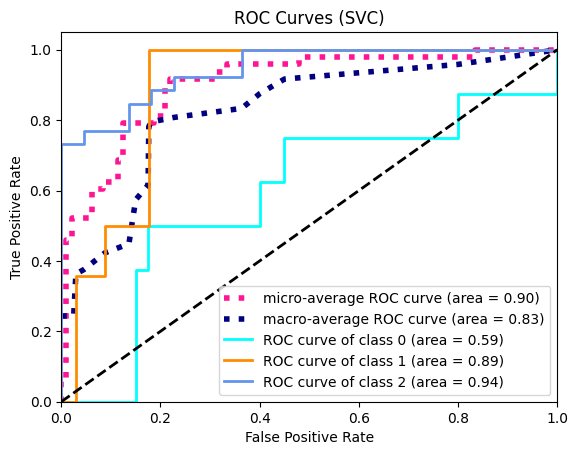

Smote PDT
Confustion Matrix
              precision    recall  f1-score   support

           A       0.70      0.88      0.78        26
           D       0.78      0.69      0.73        26
           U       1.00      0.85      0.92        26

    accuracy                           0.81        78
   macro avg       0.83      0.81      0.81        78
weighted avg       0.83      0.81      0.81        78



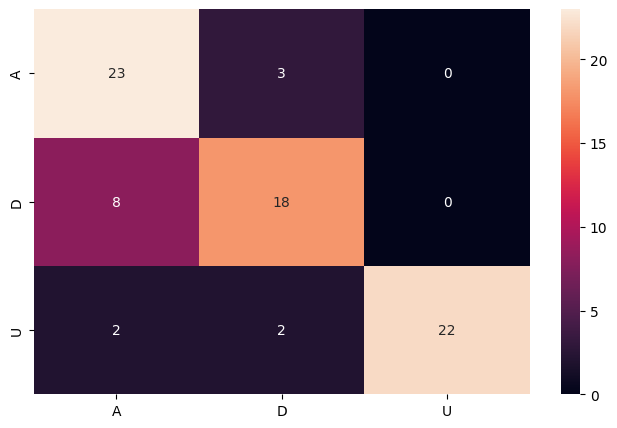

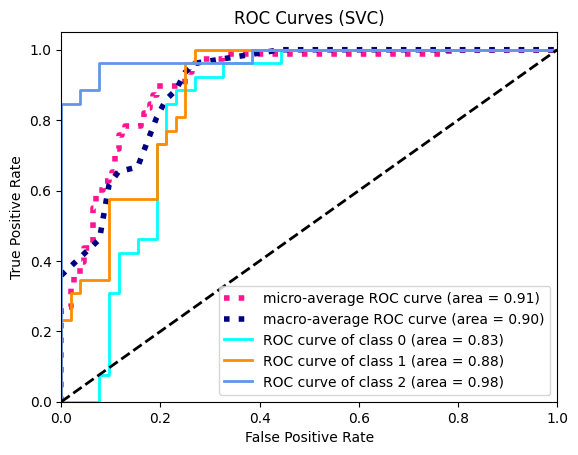

In [23]:
print('Gaussian SVM')
clfRbfSVM = sklearn.svm.SVC(kernel='rbf',probability=True,random_state=0)
print('Balanced PDT')
clf,rbf_svm_f1_score_balanced_PDT = leave_one_out(X_balanced_PDT,Y_balanced_PDT,clfRbfSVM,normalize=True)
print('Unbalanced PDT')
clf,rbf_svm_f1_score_unbalanced_PDT = leave_one_out(X_unbalanced_PDT,Y_unbalanced_PDT,clfRbfSVM,normalize=True)
print('Smote PDT')
clf,rbf_svm_f1_score_smote_PDT = leave_one_out(X_smote_PDT,Y_smote_PDT,clfRbfSVM,normalize=True)

### Polynomial SVM

Polynomial SVM
Balanced PDT
Confustion Matrix
              precision    recall  f1-score   support

           A       1.00      0.62      0.76        13
           D       0.75      1.00      0.86        21
           U       1.00      0.86      0.92        14

    accuracy                           0.85        48
   macro avg       0.92      0.82      0.85        48
weighted avg       0.89      0.85      0.85        48



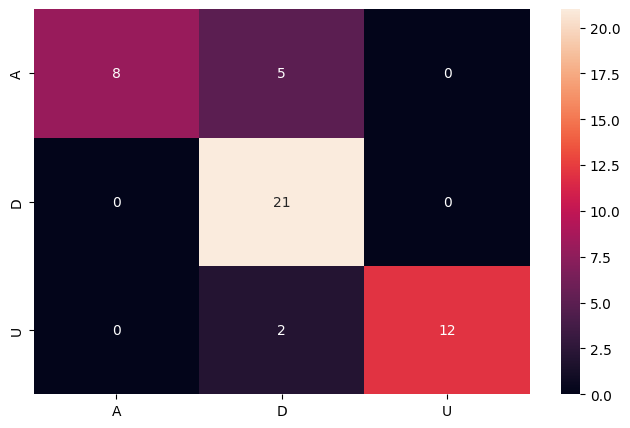

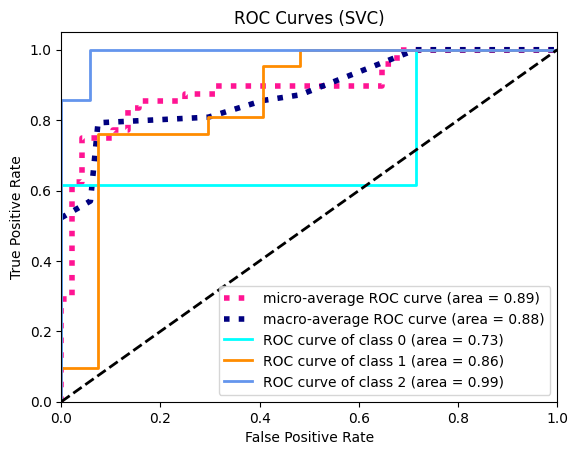

Unbalanced PDT
Confustion Matrix
              precision    recall  f1-score   support

           A       0.00      0.00      0.00         8
           D       0.67      0.43      0.52        14
           U       0.63      0.92      0.75        26

    accuracy                           0.62        48
   macro avg       0.43      0.45      0.42        48
weighted avg       0.54      0.62      0.56        48



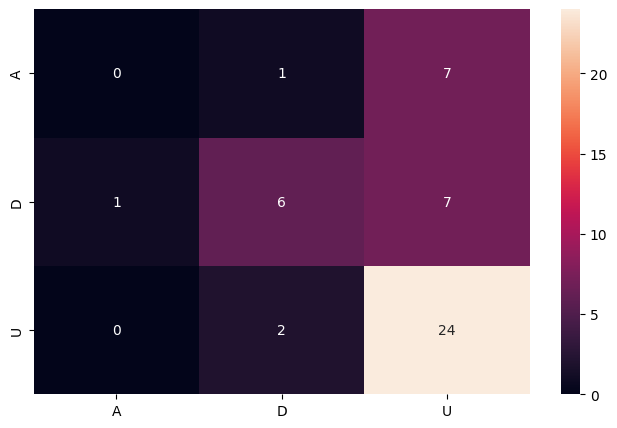

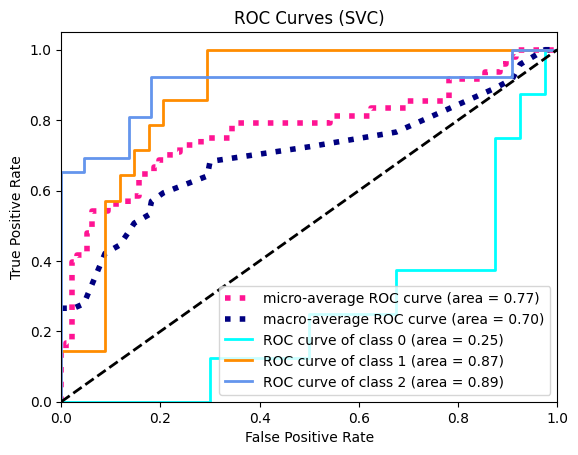

Smote PDT
Confustion Matrix
              precision    recall  f1-score   support

           A       0.61      0.96      0.75        26
           D       0.84      0.62      0.71        26
           U       1.00      0.69      0.82        26

    accuracy                           0.76        78
   macro avg       0.82      0.76      0.76        78
weighted avg       0.82      0.76      0.76        78



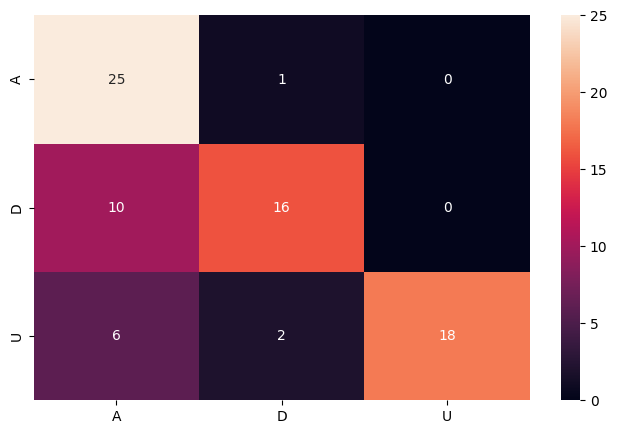

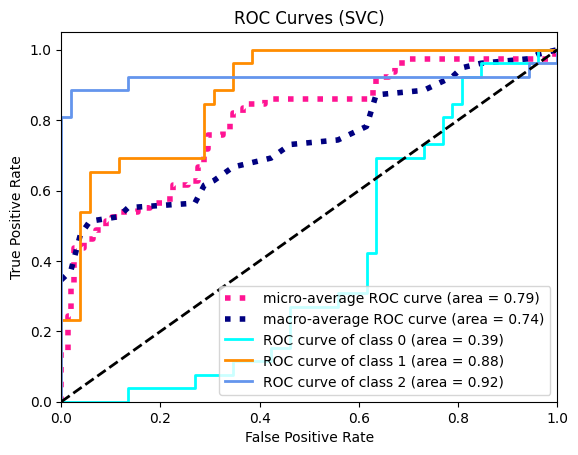

In [24]:
print('Polynomial SVM')
clfPolySVM = sklearn.svm.SVC(kernel='poly',probability=True,random_state=0)
print('Balanced PDT')
clf,poly_svm_f1_score_balanced_PDT = leave_one_out(X_balanced_PDT,Y_balanced_PDT,clfPolySVM,normalize=True)
print('Unbalanced PDT')
clf,poly_svm_f1_score_unbalanced_PDT = leave_one_out(X_unbalanced_PDT,Y_unbalanced_PDT,clfPolySVM,normalize=True)
print('Smote PDT')
clf,poly_svm_f1_score_smote_PDT = leave_one_out(X_smote_PDT,Y_smote_PDT,clfPolySVM,normalize=True)

### Decision Tree

Decision Tree Classifier
Balanced PDT
Confustion Matrix
              precision    recall  f1-score   support

           A       0.75      0.69      0.72        13
           D       0.86      0.86      0.86        21
           U       0.93      1.00      0.97        14

    accuracy                           0.85        48
   macro avg       0.85      0.85      0.85        48
weighted avg       0.85      0.85      0.85        48



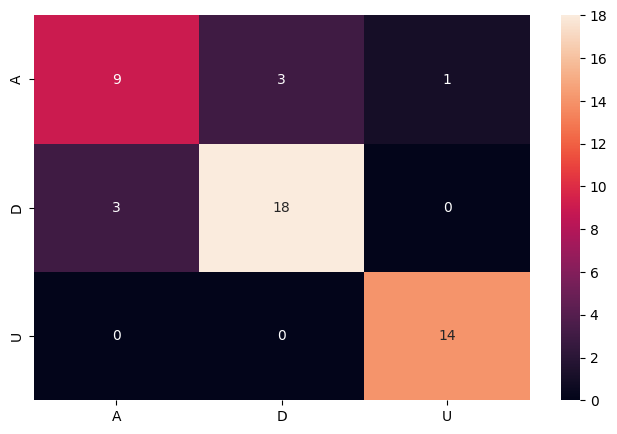

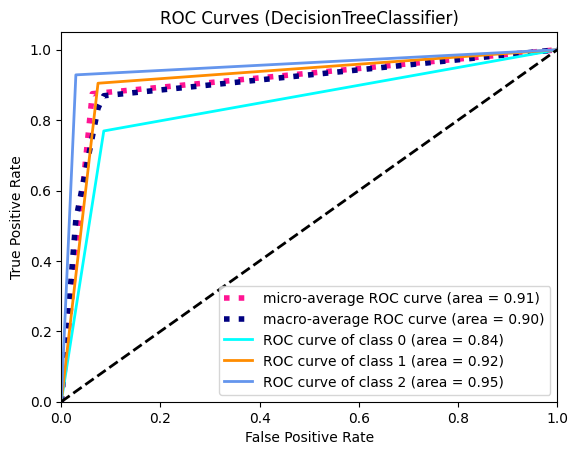

Unbalanced PDT
Confustion Matrix
              precision    recall  f1-score   support

           A       0.33      0.38      0.35         8
           D       0.73      0.79      0.76        14
           U       0.88      0.81      0.84        26

    accuracy                           0.73        48
   macro avg       0.65      0.66      0.65        48
weighted avg       0.74      0.73      0.74        48



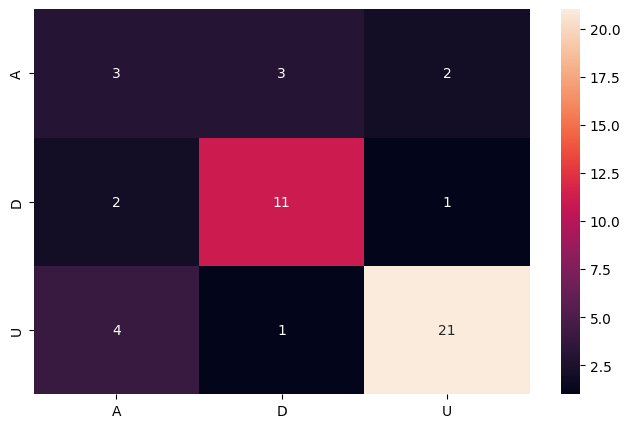

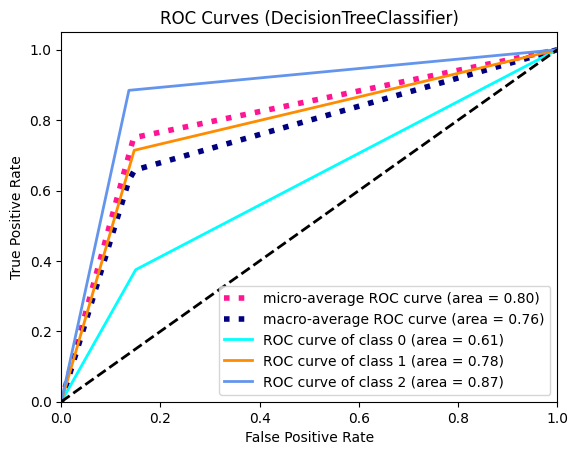

Smote PDT
Confustion Matrix
              precision    recall  f1-score   support

           A       0.72      0.69      0.71        26
           D       0.85      0.85      0.85        26
           U       0.85      0.88      0.87        26

    accuracy                           0.81        78
   macro avg       0.81      0.81      0.81        78
weighted avg       0.81      0.81      0.81        78



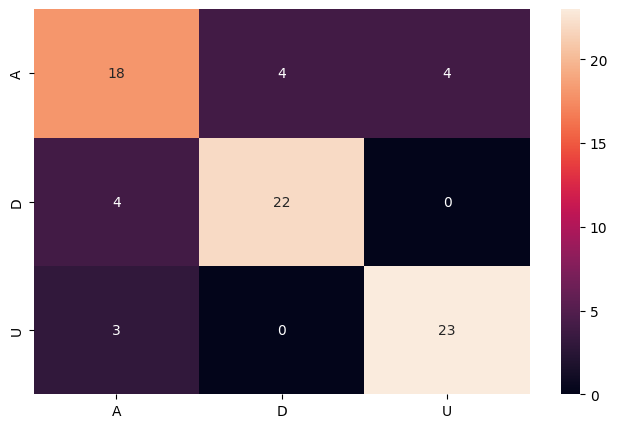

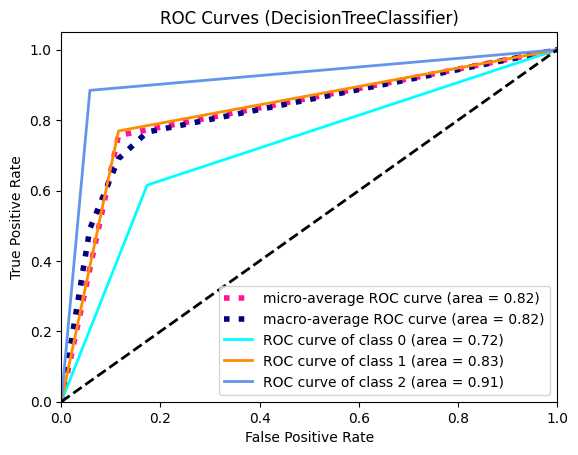

In [25]:
print('Decision Tree Classifier')
clfTree = DecisionTreeClassifier(random_state=0)
print('Balanced PDT')
clf,tree_f1_score_balanced_PDT = leave_one_out(X_balanced_PDT,Y_balanced_PDT,clfTree,normalize=True)
print('Unbalanced PDT')
clf,tree_f1_score_unbalanced_PDT = leave_one_out(X_unbalanced_PDT,Y_unbalanced_PDT,clfTree,normalize=True)
print('Smote PDT')
clf,tree_f1_score_smote_PDT = leave_one_out(X_smote_PDT,Y_smote_PDT,clfTree,normalize=True)

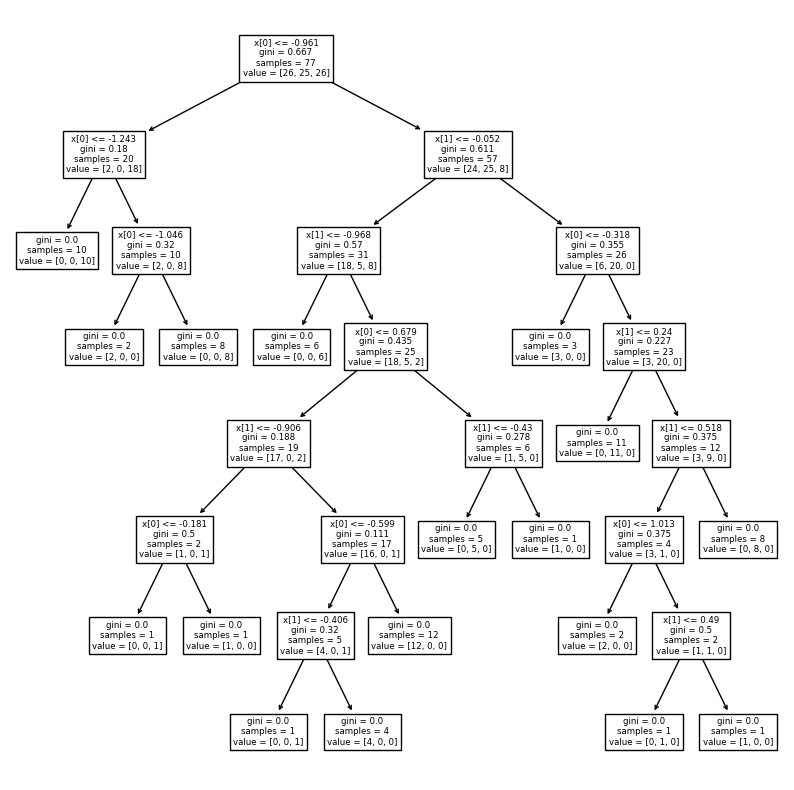

In [26]:
plt.figure(figsize=(10,10))
tree.plot_tree(clf);

### Logistic Regression

Logistic Regression
Balanced PDT
Confustion Matrix
              precision    recall  f1-score   support

           A       0.67      0.62      0.64        13
           D       0.90      0.86      0.88        21
           U       0.62      0.71      0.67        14

    accuracy                           0.75        48
   macro avg       0.73      0.73      0.73        48
weighted avg       0.76      0.75      0.75        48



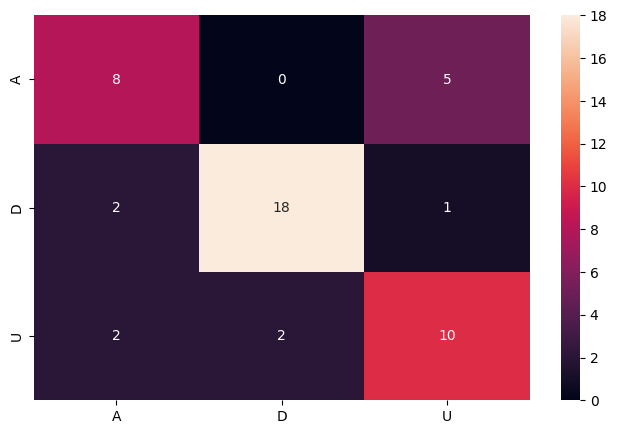

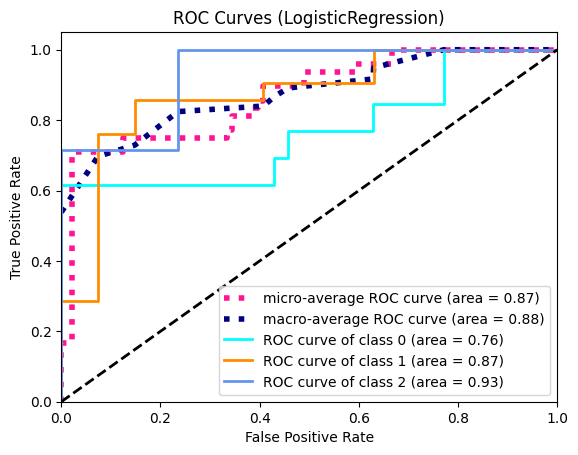

Unbalanced PDT
Confustion Matrix
              precision    recall  f1-score   support

           A       0.00      0.00      0.00         8
           D       0.67      0.86      0.75        14
           U       0.80      0.92      0.86        26

    accuracy                           0.75        48
   macro avg       0.49      0.59      0.54        48
weighted avg       0.63      0.75      0.68        48



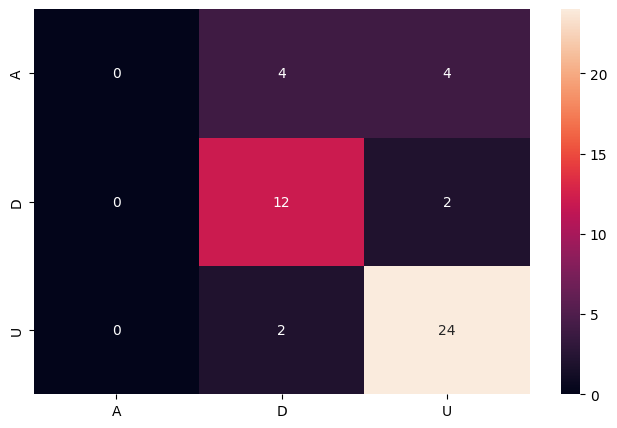

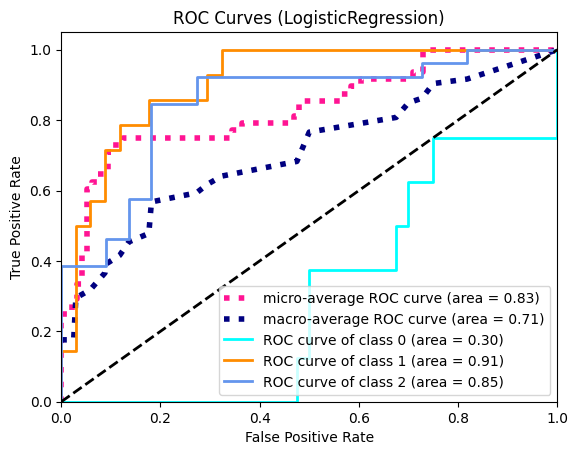

Smote PDT
Confustion Matrix
              precision    recall  f1-score   support

           A       0.36      0.31      0.33        26
           D       0.72      0.81      0.76        26
           U       0.63      0.65      0.64        26

    accuracy                           0.59        78
   macro avg       0.57      0.59      0.58        78
weighted avg       0.57      0.59      0.58        78



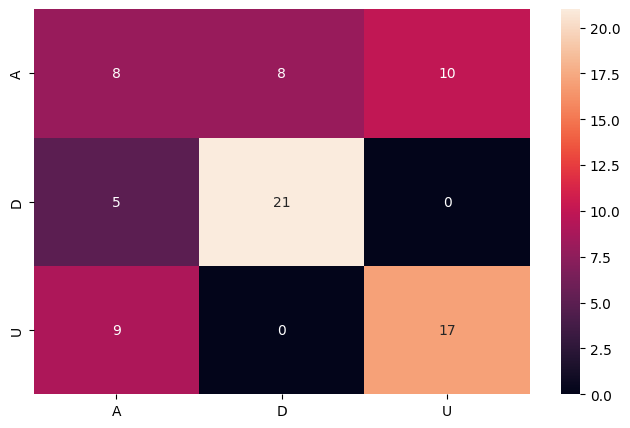

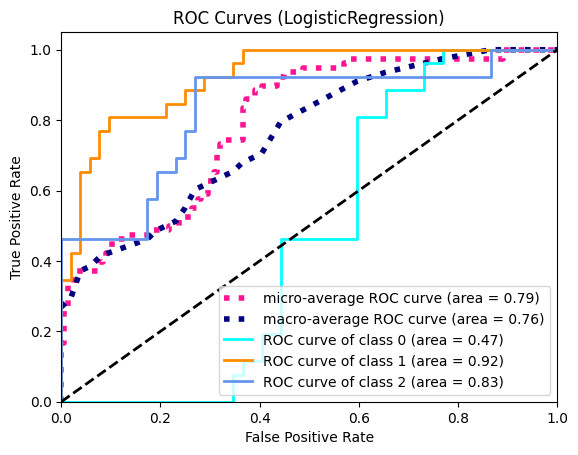

In [27]:
print('Logistic Regression')
clfLogreg = LogisticRegression(random_state=0)
print('Balanced PDT')
clf,Logreg_f1_score_balanced_PDT = leave_one_out(X_balanced_PDT,Y_balanced_PDT,clfLogreg,normalize=True)
print('Unbalanced PDT')
clf,Logreg_f1_score_unbalanced_PDT = leave_one_out(X_unbalanced_PDT,Y_unbalanced_PDT,clfLogreg,normalize=True)
print('Smote PDT')
clf,Logreg_f1_score_smote_PDT = leave_one_out(X_smote_PDT,Y_smote_PDT,clfLogreg,normalize=True)

### Comparison Balanced / Unbalanced

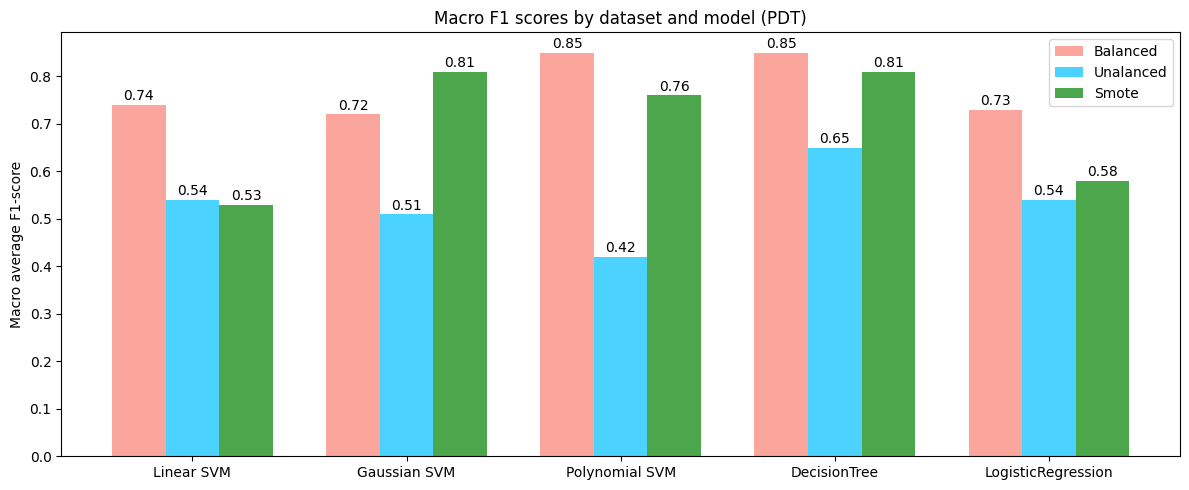

In [28]:
labels = ['Linear SVM', 'Gaussian SVM', 'Polynomial SVM', 'DecisionTree', 'LogisticRegression']
b_means = np.round([linear_svm_f1_score_balanced_PDT,rbf_svm_f1_score_balanced_PDT,poly_svm_f1_score_balanced_PDT,tree_f1_score_balanced_PDT,Logreg_f1_score_balanced_PDT],2)
ub_means = np.round([linear_svm_f1_score_unbalanced_PDT,rbf_svm_f1_score_unbalanced_PDT,poly_svm_f1_score_unbalanced_PDT,tree_f1_score_unbalanced_PDT,Logreg_f1_score_unbalanced_PDT],2)
smote_means = np.round([linear_svm_f1_score_smote_PDT,rbf_svm_f1_score_smote_PDT,poly_svm_f1_score_smote_PDT,tree_f1_score_smote_PDT,Logreg_f1_score_smote_PDT],2)

x = np.arange(len(labels)) # lables locations
width = 0.25 # width of the bars

fig, ax = plt.subplots(figsize=(12,5))
bar1 = ax.bar(x - width, b_means, width, label='Balanced', color='salmon',alpha=0.7)
bar2 = ax.bar(x, ub_means, width, label='Unalanced', color='deepskyblue',alpha=0.7)
bar3 = ax.bar(x + width, smote_means, width, label='Smote', color='green',alpha=0.7)

ax.set_ylabel('Macro average F1-score')
ax.set_title('Macro F1 scores by dataset and model (PDT)')
ax.set_xticks(x,labels)
ax.legend()

ax.bar_label(bar1,padding=1)
ax.bar_label(bar2,padding=1)
ax.bar_label(bar3,padding=1)

fig.tight_layout()

plt.show()